# Label T4SA 1.0
This notebook contains the code to label the T4SA 1.0 dataset using the predictions of the TimeLM model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.model_selection import train_test_split

BASE_DIR = "/content/drive/MyDrive/Thesis/"

DATASET_T4SA1_DIR = BASE_DIR + "dataset/t4sa/"

DATASET_T4SA1_UPDATED = DATASET_T4SA1_DIR + "new_text_predictions/bt4sa_filtered_70/"
DATASET_T4SA1_UPDATED_FILTERED = DATASET_T4SA1_DIR + "new_text_predictions/bt4sa/"

IMG_DIR = DATASET_T4SA1_DIR + "img/"

Mounted at /content/drive


In [ ]:
# Utilities

def check_label_with_filter_flat(row):
  '''Returns the label corresponding to the argmax on the predictions only if above the threshold, otherwise returns 'Too low'.'''
  THRESHOLD = 0.70
  maximum_value = max(row[1:4]) # In column 1 there is the TWID
  if row[1] == maximum_value:
    label = '0'
  elif row[2] == maximum_value:
    label = '1'
  else:
    label = '2'
  if maximum_value > THRESHOLD:
    return label
  else:
    return 'Too low'


def check_label_with_filter_70_90(row):
  '''Returns the string corresponding to the argmax on the predictions only if above the threshold, otherwise return 'Too low'.'''
  THRESHOLD_NEGATIVE = 0.70
  THRESHOLD_POSITIVE = 0.90
  maximum_value = max(row[1:4])  # In column 1 there is the TWID
  if row[1] == maximum_value:
    label = '0'
    threshold = THRESHOLD_NEGATIVE
  elif row[2] == maximum_value:
    label = '1'
    threshold = THRESHOLD_POSITIVE
  else:
    label = '2'
    threshold = THRESHOLD_POSITIVE

  if maximum_value > threshold:
    return label
  else:
    return 'Too low'


def check_label(row):
  '''Returns the label corresponding to the argmax on the predictions without filters.'''
  maximum_value = max(row[1:4])  # In column 1 there is the TWID
  if row[1] == maximum_value:
    label = '0'
  elif row[2] == maximum_value:
    label = '1'
  else:
    label = '2'
  return label

def plot_dataset_composition(dataset, saving_name=None):
  '''Plot the dataset distribution of classes in a pie chart and also save it with the name specified as input.'''

  dataset["label"] = dataset["label"].apply(int)   # convert all the labels to int
  results_filtered = {}

  for i in range(3):
    results_filtered[i] = len(dataset[dataset["label"] == i])

  print(f"- Number of Positive: {results_filtered[2]:9,d}")
  print(f"- Number of Neutral:  {results_filtered[1]:9,d}")
  print(f"- Number of Negative: {results_filtered[0]:9,d}")
  print("-"*32)
  print(f"Total: {sum(results_filtered.values()):24,d}")
  
  labels = ["Negative"," Neutral", "Positive"]
  colors = ["#FF0000", "#FFEC00", "#52D726"]   
  
  fig1, ax1 = plt.subplots()
  ax1.pie(results_filtered.values(),  labels=labels, autopct='%1.1f%%', colors=colors)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  
  if saving_name:
    plt.savefig(IMG_DIR + saving_name, dpi=1200)  # save the pie chart

  plt.show()

# B-T4SA 1.0 original
This dataset is identical to the original dataset with unaltered labels.

Statistics on the version B-T4SA 1.0 original:
- Number of Positive:   156,862
- Number of Neutral:    156,862
- Number of Negative:   156,862
--------------------------------
Total:                  470,586


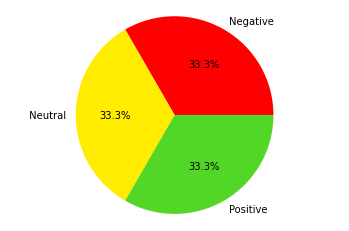

In [ ]:
bt4sa1_original = pd.read_csv(DATASET_T4SA1_DIR + "/original_text_predictions/b-t4sa_all.txt", delimiter=" ", header=None, names=["path", "label"], dtype=str)
print("Statistics on the version B-T4SA 1.0 original:")
plot_dataset_composition(bt4sa1_original, saving_name="bt4sa1_original.eps")

## B-T4SA 1.0 updated
This dataset has the same sample of the original, but with labels assigned with the TimeLM model.

Statistics on the version B-T4SA 1.0 updated:
- Number of Positive:   193,019
- Number of Neutral:    182,295
- Number of Negative:    95,272
--------------------------------
Total:                  470,586


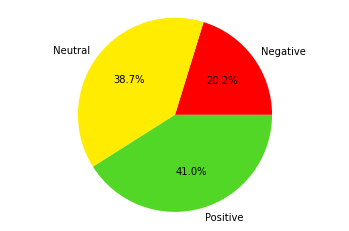

In [ ]:
bt4sa1_imgs = pd.read_csv(DATASET_T4SA1_DIR + "/original_text_predictions/b-t4sa_all.txt", delimiter=" ", header=None, names=["path", "class"], dtype=str)
t4sa1_text_predictions = pd.read_csv(DATASET_T4SA1_DIR + "/new_text_predictions/3.5M_predictions.tsv", delimiter="\t")
t4sa1_text_predictions['TWID'] = t4sa1_text_predictions['TWID'].apply(int)

bt4sa1_imgs['id_tweet'] = bt4sa1_imgs["path"].apply(lambda x: x[11:11+18]).apply(int)   # Obtain the TWID from the path

# Assign labels to images merging on the Tweet identifier
bt4sa1_updated = pd.merge(bt4sa1_imgs, t4sa1_text_predictions, how='left', left_on=['id_tweet'], right_on=['TWID']).drop([ "class", "id_tweet"], axis=1)

# just change the column order
cols = bt4sa1_updated.columns.tolist()
cols = cols[1:] + cols[:1]
bt4sa1_updated = bt4sa1_updated[cols]

bt4sa1_updated['label'] = bt4sa1_updated.apply(check_label, axis=1)

# drop useless information
bt4sa1_updated.drop([ "TWID", "NEG", "NEU", "POS"], axis=1, inplace=True)

bt4sa1_updated.to_csv(DATASET_T4SA1_UPDATED + "bt4sa1_updated.csv", index=None)

print("Statistics on the version B-T4SA 1.0 updated:")
plot_dataset_composition(bt4sa1_updated, saving_name="bt4sa1_updated.eps")

Statitics on T4SA updated split in train/test/val:
- Number of Positive:   154,415
- Number of Neutral:    145,836
- Number of Negative:    76,217
--------------------------------
Total:                  376,468


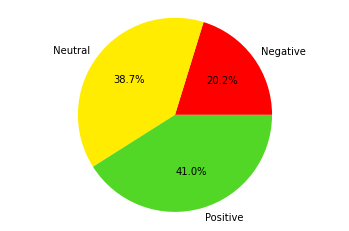

- Number of Positive:    19,302
- Number of Neutral:     18,229
- Number of Negative:     9,528
--------------------------------
Total:                   47,059


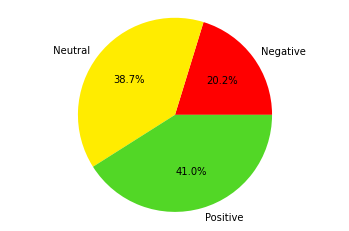

- Number of Positive:    19,302
- Number of Neutral:     18,230
- Number of Negative:     9,527
--------------------------------
Total:                   47,059


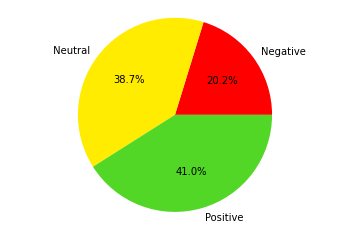

In [ ]:
# 80/10/10 train/val/test split
train_annot, valtest_annot = train_test_split(bt4sa1_updated, test_size=0.2, random_state=42, shuffle=True, stratify=bt4sa1_updated["label"])
val_annot, test_annot = train_test_split(valtest_annot, test_size=0.5, shuffle=True, stratify=valtest_annot["label"])

train_annot = train_annot.reset_index(drop=True)
val_annot = val_annot.reset_index(drop=True)
test_annot = test_annot.reset_index(drop=True)

print("Statitics on T4SA updated split in train/test/val:")
plot_dataset_composition(train_annot, saving_name=None)
plot_dataset_composition(val_annot, saving_name=None)
plot_dataset_composition(test_annot, saving_name=None)

train_annot.to_csv(DATASET_T4SA1_UPDATED + "t4sa_updated_train.csv", index=None)
val_annot.to_csv(DATASET_T4SA1_UPDATED + "t4sa_updated_val.csv", index=None)
test_annot.to_csv(DATASET_T4SA1_UPDATED + "t4sa_updated_test.csv", index=None)

# B-T4SA 1.0 updated filtered
This dataset has less sample respect to the original one, it is not balanced and labels are assigned with the TimeLM model.

Statistics on the version B-T4SA 1.0 updated and filtered:
- Number of Positive:   169,459
- Number of Neutral:    130,712
- Number of Negative:    64,576
--------------------------------
Total:                  364,747


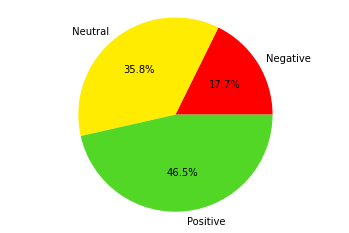

In [ ]:
bt4sa1_imgs = pd.read_csv(DATASET_T4SA1_DIR + "/original_text_predictions/b-t4sa_all.txt", delimiter=" ", header=None, names=["path", "class"], dtype=str)
t4sa1_text_predictions = pd.read_csv(DATASET_T4SA1_DIR + "/new_text_predictions/3.5M_predictions.tsv", delimiter="\t")
t4sa1_text_predictions['TWID'] = t4sa1_text_predictions['TWID'].apply(int)

bt4sa1_imgs['id_tweet'] = bt4sa1_imgs["path"].apply(lambda x: x[11:11+18]).apply(int)  # Obtain the TWID from the path

# Assign labels to images merging on the Tweet identifier
bt4sa1_img_updated_filtered = pd.merge(bt4sa1_imgs, t4sa1_text_predictions, how='left',left_on=['id_tweet'], right_on=['TWID']).drop([ "class", "id_tweet"], axis=1)

# just change the column order
cols = bt4sa1_img_updated_filtered.columns.tolist()
cols = cols[1:] + cols[:1]  
bt4sa1_img_updated_filtered = bt4sa1_img_updated_filtered[cols]

# apply the filtering based on the confidence threshold
bt4sa1_img_updated_filtered['label'] = bt4sa1_img_updated_filtered.apply(check_label_with_filter_flat, axis=1)

# drop useless information
bt4sa1_img_updated_filtered.drop([ "TWID", "NEG", "NEU", "POS"], axis=1, inplace=True)

# Remove all the tweets with a label below the confidence
bt4sa1_img_updated_filtered = bt4sa1_img_updated_filtered[bt4sa1_img_updated_filtered['label'] != "Too low"]

bt4sa1_img_updated_filtered.to_csv(DATASET_T4SA1_UPDATED_FILTERED + "bt4sa1_updated_filtered.csv", index=None)

print("Statistics on the version B-T4SA 1.0 updated and filtered:")
plot_dataset_composition(bt4sa1_img_updated_filtered, saving_name="bt4sa1_updated_filtered.eps")

Statistics on B-T4SA 1.0 updated and filtered split in train/test/val:
- Number of Positive:   135,567
- Number of Neutral:    104,569
- Number of Negative:    51,661
--------------------------------
Total:                  291,797


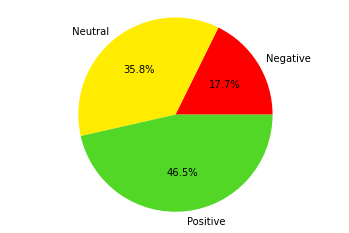

- Number of Positive:    16,946
- Number of Neutral:     13,072
- Number of Negative:     6,457
--------------------------------
Total:                   36,475


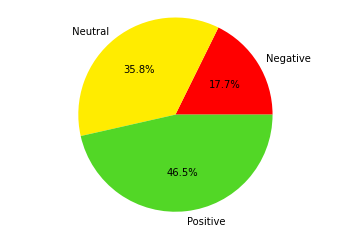

- Number of Positive:    16,946
- Number of Neutral:     13,071
- Number of Negative:     6,458
--------------------------------
Total:                   36,475


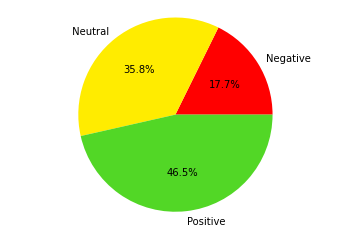

In [ ]:
# 80/10/10 train/val/test split
train_annot, valtest_annot = train_test_split(bt4sa1_img_updated_filtered, test_size=0.2, random_state=42, shuffle=True, stratify=bt4sa1_img_updated_filtered["label"])
val_annot, test_annot = train_test_split(valtest_annot, test_size=0.5, shuffle=True, stratify=valtest_annot["label"])

train_annot = train_annot.reset_index(drop=True)
val_annot = val_annot.reset_index(drop=True)
test_annot = test_annot.reset_index(drop=True)

print("Statistics on B-T4SA 1.0 updated and filtered split in train/test/val:")
plot_dataset_composition(train_annot, saving_name=None)
plot_dataset_composition(val_annot, saving_name=None)
plot_dataset_composition(test_annot, saving_name=None)

train_annot.to_csv(DATASET_T4SA1_UPDATED_FILTERED + "t4sa_updated_filtered_train.csv", index=None)
val_annot.to_csv(DATASET_T4SA1_UPDATED_FILTERED + "t4sa_updated_filtered_val.csv", index=None)
test_annot.to_csv(DATASET_T4SA1_UPDATED_FILTERED + "t4sa_updated_filtered_test.csv", index=None)